In [8]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
from plotScripts import plotScatterGeneric, plotBAGeneric, plotGeom
from stenosis_models import itu_etal_model_coeffs
#===================================================
#===================================================
def load_obj3(name , folder):
    with open(os.path.join(folder, name + '.pkl'), 'rb') as f:
        return pickle.load(f, encoding='latin1')

def plotGeom_all(x_all, r_all):
    plt.figure()
    
    y_max = 0
    for n in range(len(x_all)):
        plt.plot(x_all[n], r_all[n])
        
        if max(r_all[n]) > y_max:
            y_max = max(r_all[n])
    plt.ylim((0, 1.1*y_max))
    plt.xlabel("x [cm]")
    plt.ylabel("r [cm]")
    #plt.title(stenoCase + "_" + trainOrTest)

def plotData_DP(DP_3D, DP_3D_ori, DP_1D):
    
    plotScatterGeneric(DP_3D_ori, DP_3D, "DP_3D_ori", "DP_3D", None, savePlots=False)
    
    plotBAGeneric(DP_3D_ori, DP_3D, "DP_3D_ori", "DP_3D", None, savePlots=False)

    plotScatterGeneric(DP_3D, DP_1D, "DP_3D", "DP_1D", None, savePlots=False)
    
    plotBAGeneric(DP_3D, DP_1D, "DP_3D", "DP_1D", None, savePlots=False)
#===================================================

def plotDataSets(geomTypes, trainOrTestCases, plotGeomOnly=False):
    for trainOrTest in trainOrTestCases:
        x_all = []
        r_all = []
        figName = "geoms"
        for stenoCase in geomTypes:
            stenoParams, x, r = loadCaseData(stenoCase, trainOrTest, createPlots=True, plotGeomOnly=plotGeomOnly)
            
            x_all.append(x)
            r_all.append(r)
            figName += "_" + stenoCase 
        plotGeom_all(x_all, r_all)
        
#===================================================
def loadCaseData(stenoCase, trainOrTest, createPlots=False, plotGeomOnly=False):

    stenoFolderNameGen = "x_vs_r_30_geom_"
    stenoFolderName = "x_vs_r_30_geom_{}".format(stenoCase)
    stenoFileName = "stenosesDP_{}_30_id_FOAM_x_vs_r_30_geom_{}".format(trainOrTest, stenoCase)
    stenoFolder = os.path.join(pathToDataFolder, stenoFolderName)
    
    stenoFilePath = os.path.join(stenoFolder, stenoFileName)
    
    stenoParams = load_obj(stenoFileName, stenoFolder)
    x_max, r_max = None, None
    
    if createPlots:
        DP_3D = []
        DP_3D_ori = []
        DP_1D = []
        DP_max = 0
        n_max = None
        for n in range(len(stenoParams)):

            DP_3D.append(stenoParams[n]["DPmmHg"])
            DP_3D_ori.append(stenoParams[n]["DP3D_ori"])
            DP_1D.append(stenoParams[n]["deltaP1D"])

            if stenoParams[n]["DP3D_ori"] > DP_max:
                n_max = n
                DP_max = stenoParams[n]["DP3D_ori"]
        x_max = stenoParams[n_max]["x"]
        r_max = stenoParams[n_max]["r"]


        DP_3D = np.array(DP_3D)
        DP_3D_ori = np.array(DP_3D_ori)
        DP_1D = np.array(DP_1D)
        if plotGeomOnly == False:
            plotData_DP(DP_3D, DP_3D_ori, DP_1D)
        #plotGeom(x_max, r_max, figFolder, stenoCase, trainOrTest)
    
    return stenoParams, x_max, r_max

#===================================================
def extractRadiusData(stenoParamsList, trainOrTest):
    
    x_interp_norm = np.linspace(0, 1, 100) 
    r_interp = []
    r_interp_norm = []
    trainOrTestList = []
    for n_case in range(len(stenoParamsList)):
        
        for n_steno in range(len(stenoParamsList[n_case])):
            
            stenoDict = stenoParamsList[n_case][n_steno]
            
            x = stenoDict["x"] # [cm]
            r = stenoDict["r"] # [cm]
            l = x[-1] - x[0]
            x_norm = x[:]/l
            r_norm = r[:]/max(r)
            r_interp.append(np.interp(x_interp_norm, x_norm, r))
            r_interp_norm.append(np.interp(x_interp_norm, x_norm, r_norm))
            
            if trainOrTest == "train":
                trainOrTestList.append(1)
            else:
                trainOrTestList.append(0)
    
    return np.array(x_interp_norm), np.array(r_interp), np.array(r_interp_norm), np.array(trainOrTestList)
    
#===================================================
def calcPCA(geomTypes, trainOrTestCases, Ncomponents=5):
    
    x, r, r_norm, trainOrTestList = None, None, None, None
    for n_trainOrTest, trainOrTest in enumerate(trainOrTestCases):
        stenoParamsList = []
        for stenoCase in geomTypes:
            stenoParams, xxx, rrr = loadCaseData(stenoCase, trainOrTest)
                      
            stenoParamsList.append(stenoParams)
    
        x_tmp, r_tmp, r_norm_tmp, trainOrTestList_tmp = extractRadiusData(stenoParamsList, trainOrTest)
        
        if n_trainOrTest == 0:
            x, r, r_norm, trainOrTestList = x_tmp, r_tmp[:,:], r_norm_tmp[:,:], trainOrTestList_tmp[:]
        
        else:
            #print(np.shape(r), np.shape(r_tmp))
            #x = np.vstack((x, x_tmp))
            r = np.vstack((r, r_tmp))
            r_norm = np.vstack((r_norm, r_norm_tmp))
            trainOrTestList = np.append(trainOrTestList, trainOrTestList_tmp)
                    
    X = r_norm - np.mean(r_norm, axis=0) #PCA assumes 0-mean data
    
    
    cov_mat = (X.T).dot(X)/(X.shape[0] - 1)
    
    ev, v = np.linalg.eig(cov_mat)
    
    ev_sort_idx = np.argsort(-np.abs(ev))
    ev_sorted = ev[ev_sort_idx]
    v_sorted = v[:,ev_sort_idx]
    
    #scores = X @ v_sorted
    scores = X.dot(v_sorted)
    scores = np.real(scores[:, 0:Ncomponents])
    train_ids = np.where(trainOrTestList > 0.5)
    test_ids = np.where(trainOrTestList < 0.5)
    train_scores = scores[train_ids]
    test_scores = scores[test_ids]
    
    return scores, train_scores, test_scores

#===================================================
def extractData(stenoParamsList, geomTypes, PCA_scores, featureNames, dataName, saveFile=False, mu=0.035, rho=1.05):
    
    #featureNames = ["r_in", "r_min", "r_out", "l", "l_in", "l_out", 
    #                "l_in_norm", "DP_3D_ori", "DP_3D", "DP_0D", "epsilonDP", "Q", 
    #               "geomId", "splitCol", "geomId2", "DP_1D_sol" , "stenoId", 
    #                "PCA_0", "PCA_1", "PCA_2", "PCA_3", "PCA_4", 
    #                "epsilonDP_ori", "epsilonDP_sol", "Re"]
    nCols = len(featureNames)
    nRows = 0
    for n_case in range(len(stenoParamsList)):
        
        for n_steno in range(len(stenoParamsList[n_case])):
            nRows += 1
    
    dataTot = np.zeros((nRows, nCols))
    geomId = 0
    rowId = 0
    for n_case in range(len(stenoParamsList)):
        
        for n_steno in range(len(stenoParamsList[n_case])):
            
            stenoDict = stenoParamsList[n_case][n_steno]
            
            x = stenoDict["x"] # [cm]
            r = stenoDict["r"] # [cm]
            DP_3D = stenoDict["DPmmHg"]
            DP_3D_ori = stenoDict["DP3D_ori"]
            DP_1D_sol = stenoDict["deltaP1D"]
            Q = stenoDict["Q"]
            
            
            
            #patientID = stenoDict["patientID"]
            #branchName = stenoDict["side"]
            #simulation = stenoDict["simulation"]
            stenoId = stenoDict["stenoId"]
            splitCol = stenoDict["splitCol"]
            r_in = r[0]
            r_min = min(r)
            r_out = r[-1]
            r0 = 0.5*(r_in + r_out)
            l = x[-1] - x[0]
            l_in = x[np.argmin(r)] - x[0]
            if geomTypes[n_case] == "abrupt":
                l_in = 0.5*l
            l_out = l - l_in
            l_in_norm = l_in/l
            
            a0 = np.pi*r0**2
            aS = np.pi*r_min**2
            a, b = itu_etal_model_coeffs(x, r, a0, a0, a0, aS, l, l, mu, rho)

            a /= 1333.22
            b /= 1333.22
        
            DP_0D = a*Q + b*Q**2
            
            if "arc" in geomTypes[n_case]:
                geomId2 = 1
            elif "abrupt" in geomTypes[n_case]:
                geomId2 = 2
            elif "triangle" in geomTypes[n_case]:
                geomId2 = 3
            else:
                geomId2 = 0
            
            
            Re = (Q/aS)*rho*r_min*2/mu
            
            
            tmpDict = {"r_in": r_in,
                       "r_min": r_min,
                       "r_out": r_out,
                       "l": l,
                       "l_in": l_in,
                       "l_out": l_out,
                       "DP_3D": DP_3D,
                       "DP_3D_ori": DP_3D_ori,
                       "DP_1D_sol": DP_1D_sol,
                       "DP_0D": DP_0D,
                       "epsilonDP": DP_3D - DP_0D,
                       "epsilonDP_ori": DP_3D_ori - DP_0D,
                       "epsilonDP_sol": DP_3D - DP_1D_sol,
                       "Q": Q,
                       "geomId": geomId,
                       "geomId2":geomId2,
                       "stenoId":stenoId,
                       "splitCol": splitCol,
                       "l_in_norm":l_in_norm,
                       "PCA_0":PCA_scores[rowId, 0],
                       "PCA_1":PCA_scores[rowId, 1],
                       "PCA_2":PCA_scores[rowId, 2],
                       "PCA_3":PCA_scores[rowId, 3],
                       "PCA_4":PCA_scores[rowId, 4],
                       "Re": Re}
            
            dataTmp = np.zeros((1, len(featureNames)))

            for colId in range(nCols):
                #print(featureIdx, featureNames[colId], tmpDict[featureNames[colId]])
                dataTot[rowId, colId] = tmpDict[featureNames[colId]]
            
            rowId += 1
            
            #print(n_steno)
        
        geomId += 1
    
    if saveFile:
        headerText = ""

        for colId in range(nCols):
            headerText += featureNames[colId] + "_" + str(colId)
            headerText += " "
        np.savetxt(dataName, dataTot, header=headerText)
    
    return dataTot
    
#===================================================    
def createAppendedDatasets(geomTypes, trainOrTestCases, featureNames, dataFolder='', dataName=''):
    #createDirIfEmpty(dataFolder)
    data_train = None
    data_test = None
    scores, train_scores, test_scores = calcPCA(geomTypes, trainOrTestCases)
    for trainOrTest in trainOrTestCases:
        stenoParamsList = []
        for stenoCase in geomTypes:
            stenoParams, x, r = loadCaseData(stenoCase, trainOrTest)
                      
            stenoParamsList.append(stenoParams)
            
        dataNameTmp = os.path.join(dataFolder, dataName + "_" + trainOrTest)
        
        if trainOrTest == "train":
            data_train = extractData(stenoParamsList, geomTypes, train_scores, featureNames, dataNameTmp, saveFile=False)
        else:
            data_test = extractData(stenoParamsList, geomTypes, test_scores, featureNames, dataNameTmp, saveFile=False)
    
    return data_train, data_test

(2482, 25) (2036, 25)


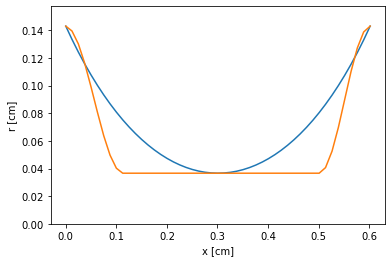

In [9]:
import os
import numpy as np
import keras
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
tf.logging.set_verbosity(tf.logging.ERROR) # depreciate warnings

#===================================================
# define path to database, and features to extract
#===================================================
load_obj = load_obj3

pathToDataFolder = "x_vs_r_30_geom_V2"

featureNames = ["r_in", "r_min", "r_out", "l", "l_in", "l_out", 
                "l_in_norm", "DP_3D_ori", "DP_3D", "DP_0D", "epsilonDP", "Q", 
                "geomId", "splitCol", "geomId2", "DP_1D_sol" , "stenoId", 
                "PCA_0", "PCA_1", "PCA_2", "PCA_3", "PCA_4", 
                "epsilonDP_ori", "epsilonDP_sol", "Re"]

featureNamesDict = {"r_in":0, "r_min":1, "r_out": 2, "l": 3, "l_in":4, "l_out":5, "l_in_norm":6,
                    "DP_3D_ori":7, "DP_3D": 8, "DP_0D":9, "epsilonDP": 10, "Q": 11, "geomId": 12,
                    "splitCol": 13, "geomId2": 14, "DP_1D_sol": 15, "stenoId": 16, "PCA_0": 17,
                    "PCA_1": 18, "PCA_2": 19, "PCA_3": 20, "PCA_4": 21, "epsilonDP_ori": 22, 
                    "epsilonDP_sol": 23, "Re": 24}

#===================================================
# select stenoses geometries to include
# select from ["ori", "arc", "abrupt", "poly5", "triangle", 
#              "arcSymmetricFalseAvgFalse", "abruptSymmetricFalseAvgFalse", 
#              "triangleSymmetricFalseAvgFalse"]
#===================================================
geomTypes = ["arc", "abrupt"]
#===================================================
# load and plot data
#===================================================

trainOrTestCases = ["train", "test"]

plotDataSets(geomTypes, ["train"], plotGeomOnly=True)

data_train, data_test = createAppendedDatasets(geomTypes, trainOrTestCases, featureNames)

print(np.shape(data_train), np.shape(data_test))

In [14]:
#===================================================
# set labels and features
#===================================================
labelN = "epsilonDP" # 10:epsilonDP, 8: DP_3D, 7: DP_3D_ori

fetureN = ["r_in", "r_min", "l", "Q", "DP_0D", "PCA_1", "PCA_2", "PCA_3"] #, "PCA_1", "PCA_2", "PCA_3"]
splitByColumn = featureNamesDict["splitCol"]
labelCol = featureNamesDict[labelN]
featureCols = []
print(labelCol)

for n in range(len(fetureN)):
    featureCols.append(featureNamesDict[fetureN[n]])
print(labelCol, featureCols)
#===================================================
# extract features and labels from training set and split 
# into actual training and validation sets
#===================================================
splitCol = data_train[:,splitByColumn].copy()

x, y = data_train[:,featureCols].copy(), data_train[:,labelCol].copy()
y.resize(y.size, 1)
splitCol = data_train[:,splitByColumn].copy()


train_X = x[splitCol==1,:]
val_X = x[splitCol==0,:]
train_Y = y[splitCol==1,:]
val_Y = y[splitCol==0,:]
print(np.shape(train_X), np.shape(val_X), np.shape(train_X), np.shape(val_X))
#===================================================
# extract features and labels from testing set
#===================================================
test_X, test_Y = data_test[:,featureCols].copy(), data_test[:,labelCol].copy()
test_Y.resize(test_Y.size, 1)
#===================================================
# scale inputs
#===================================================
scaler = preprocessing.StandardScaler()
train_X = scaler.fit_transform(train_X) # fit (find mu and std) scaler and transform data
val_X  = scaler.transform(val_X) # transform data based on mu and std from training/learning set
test_X = scaler.transform(test_X)
#===================================================
# set parameters for Neural net
#===================================================
afFunc = "relu"
opt = 'adagrad'
lossFunc= 'mae'
max_epochs = 300
batch_size = 100
layers = [50, 50]
stdW = 0.1
stdB = 0.1
seed = 3
numFeatures = len(featureCols)

10
10 [0, 1, 3, 11, 9, 18, 19, 20]
(1840, 8) (642, 8) (1840, 8) (642, 8)


In [15]:
#===================================================
# set up Neural net with Keras
#===================================================
model = keras.Sequential()
# input layer
model.add(keras.layers.Dense(layers[0], input_shape=(numFeatures,), 
                             kernel_initializer=keras.initializers.RandomNormal(stddev=stdW,seed=seed),
                             bias_initializer=keras.initializers.RandomNormal(stddev=stdB,seed=seed),
                             activation=afFunc))
# hidden layers
for n in range(len(layers) - 1):
    model.add(keras.layers.Dense(layers[n + 1], 
                                 kernel_initializer=keras.initializers.RandomNormal(stddev=stdW,seed=seed),
                                 bias_initializer=keras.initializers.RandomNormal(stddev=stdB,seed=seed),
                                 activation=afFunc))
# output layers
model.add(keras.layers.Dense(1, activation='linear', 
                             kernel_initializer=keras.initializers.RandomNormal(stddev=stdW,seed=seed)))

model.compile(optimizer=opt,
              loss=lossFunc)

In [ ]:
#===================================================
# train model
#===================================================
model.fit(train_X, train_Y, epochs=max_epochs, batch_size=batch_size, verbose=1)

#plotScatterGeneric(val_Y, val_Y_pred, "DP", "PP_ML")

Epoch 1/300
1840/1840 [==============================] - 0s 68us/step - loss: 0.8371
Epoch 2/300
1840/1840 [==============================] - 0s 15us/step - loss: 0.6042
Epoch 3/300
1840/1840 [==============================] - 0s 14us/step - loss: 0.4836
Epoch 4/300
1840/1840 [==============================] - 0s 13us/step - loss: 0.4259
Epoch 5/300
1840/1840 [==============================] - 0s 12us/step - loss: 0.3827
Epoch 6/300
1840/1840 [==============================] - 0s 13us/step - loss: 0.3503
Epoch 7/300
1840/1840 [==============================] - 0s 12us/step - loss: 0.3306
Epoch 8/300
1840/1840 [==============================] - 0s 12us/step - loss: 0.3127
Epoch 9/300
1840/1840 [==============================] - 0s 13us/step - loss: 0.2958
Epoch 10/300
1840/1840 [==============================] - 0s 13us/step - loss: 0.2836
Epoch 11/300
1840/1840 [==============================] - 0s 12us/step - loss: 0.2722
Epoch 12/300
1840/1840 [==============================] - 0s 11

1840/1840 [==============================] - 0s 13us/step - loss: 0.0795
Epoch 97/300
1840/1840 [==============================] - 0s 13us/step - loss: 0.0791
Epoch 98/300
1840/1840 [==============================] - 0s 12us/step - loss: 0.0794
Epoch 99/300
1840/1840 [==============================] - 0s 15us/step - loss: 0.0778
Epoch 100/300
1840/1840 [==============================] - 0s 13us/step - loss: 0.0763
Epoch 101/300
1840/1840 [==============================] - 0s 15us/step - loss: 0.0780
Epoch 102/300
1840/1840 [==============================] - 0s 14us/step - loss: 0.0776
Epoch 103/300
1840/1840 [==============================] - 0s 14us/step - loss: 0.0767
Epoch 104/300
1840/1840 [==============================] - 0s 13us/step - loss: 0.0756
Epoch 105/300
1840/1840 [==============================] - 0s 13us/step - loss: 0.0746
Epoch 106/300
1840/1840 [==============================] - 0s 13us/step - loss: 0.0760
Epoch 107/300
1840/1840 [==============================] - 0

In [ ]:
#val_Y_pred = model.predict(val_X).flatten()
test_Y_pred = model.predict(test_X).flatten()

if labelN == "epsilonDP":
    DP_3D_col = featureNamesDict["DP_3D"]
    DP_0D_col = featureNamesDict["DP_0D"]
    DP3D_test = data_test[:,DP_3D_col].copy()
    DP0D_test = data_test[:,DP_0D_col].copy()
    DP0D_ML_test = DP0D_test + test_Y_pred
    
plotScatterGeneric(DP3D_test, DP0D_test, "DP3D", "DP0D", None, savePlots=False)
plotScatterGeneric(DP3D_test, DP0D_ML_test, "DP3D", "DP0D_ML", None, savePlots=False)
plotScatterGeneric(test_Y_pred, test_Y.flatten(), "epsilon_DP", "epsilon_DP_pred", None, savePlots=False)